# Import Module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = 'colab'
import warnings
warnings.filterwarnings('ignore')
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import spacy
import pickle

# Preview Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/amazon_alexa.tsv', sep='\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [4]:
df['review_length'] = df['verified_reviews'].apply(len)
df.head()

,rating,date,variation,verified_reviews,feedback,review_length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [5]:
ratings = df['rating'].value_counts()

fig = px.funnel_area(names=ratings.index, values=ratings.values,
                     title='Distribution of Alexa Ratings',
                     width=600, height=600)
py.iplot(fig)

In [6]:
feedback = df['feedback'].value_counts()

fig = px.pie(df, values=feedback.values, names=feedback.index,
             title='Distribution of Feedback',
             width=600, height=500)
py.iplot(fig)

In [7]:
reviews = px.histogram(df, x="review_length", 
                       color='feedback',
                       title='Distribution of Length of Reviews by Feedback',
                       labels={"review_length":"Review Length"},
                       width=1400, height=600)
py.iplot(reviews)

# Data Cleaning

In [8]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [9]:
df['verified_reviews'].head()

0                                        Love my Echo!
1                                            Loved it!
2    Sometimes while playing a game, you can answer...
3    I have had a lot of fun with this thing. My 4 ...
4                                                Music
Name: verified_reviews, dtype: object

In [10]:
# Remove emoji function (ref:https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b)
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Lowercase, remove punctuation, and remove emoji
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['verified_reviews'] = df['verified_reviews'].str.replace('[^\w\s]','')
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: remove_emoji(x))

df['verified_reviews'].sample(10)

129     so far it seems to be a very nice item it pick...
1295                                 i love the echo spot
805                   great device responsive and helpful
1074    its not perfect but i really like this little ...
2113    fast to load but keeps rebooting in middle of ...
1934                                       great  love it
2254                       great product so many features
2948    i have an echo but wanted a dot for my bedroom...
1575    after two weeks i am not sure if i like the ev...
1510    this is so fun i really enjoy using it i have ...
Name: verified_reviews, dtype: object

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop = stopwords.words('english')

# Lemmatization function
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])  

# Remove stopwords and lemmatize
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['verified_reviews'] = df['verified_reviews'].apply(space)

df['verified_reviews'].sample(10)

2124                                             easy use
935                                                  like
1453    wife use skype year talk parent daily constant...
2028          nice everything work fine 100 learn command
1138                                  love amazon product
1395    work great love grand daughter dig watch carto...
1614                                                     
516                                    pleased order want
105             speaker surprising quality happy purchase
1344    highly recommend spot connect kasa camera conv...
Name: verified_reviews, dtype: object

In [13]:
df['sentiment'] = np.where(df['rating']>= 4, 'positive', 'negative')
df.sample(5)

,rating,date,variation,verified_reviews,feedback,review_length,sentiment
97,5,30-Jul-18,Sandstone Fabric,love echo love size material speaker quality h...,1,268,positive
1940,4,26-Jul-18,White Plus,connect sound perfect give 4 internal battery ...,1,136,positive
2665,1,30-Jul-18,White Dot,real difficulty work echo dot alexi smart 9 10...,0,340,negative
2750,5,30-Jul-18,Black Dot,additional alexa base device make access well ...,1,252,positive
1714,5,28-Jul-18,White Show,buy old grandparent help reminder would recomm...,1,270,positive


# Topic Modelling & Sentiment Analysis

## WordCloud

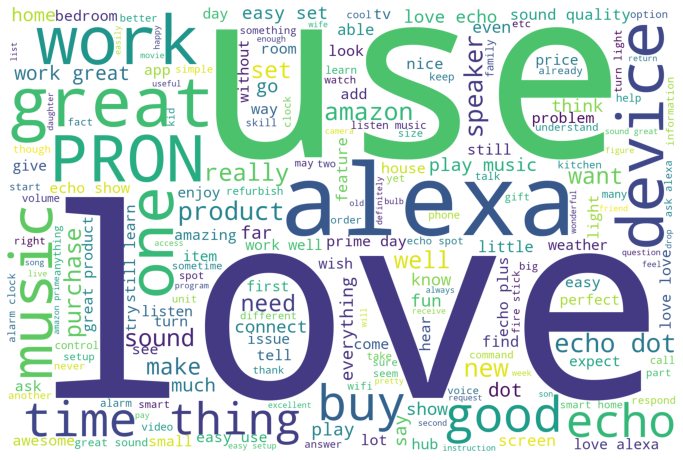

In [14]:
corpus_cloud = ' '.join(df['verified_reviews'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=1800,height=1200).generate(corpus_cloud)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Corpus

In [15]:
count_dict = {}

for doc in df['verified_reviews']:
    for word in doc.split():
        if word in count_dict.keys():
            count_dict[word] +=1
        else:
            count_dict[word] = 1
            
list(count_dict.items())[:5]

[('love', 1049), ('echo', 828), ('sometimes', 37), ('play', 320), ('game', 31)]

In [16]:
# Remove words with less than 10 occurence
clean_list = []
threshold = 10
words_to_remove = [key for key in count_dict.keys() if count_dict[key] < threshold]
corpus = [doc.split() for doc in df['verified_reviews']]
for document in corpus:
    clean_list.append([word for word in document if word not in words_to_remove])

# Join words into corpus
corpus = []
for item in clean_list:
    item = ' '.join(item)
    corpus.append(item)

print(clean_list[2])    
print(corpus[2])

['sometimes', 'play', 'game', 'answer', 'question', 'correctly', 'alexa', 'say', 'get', 'wrong', 'answer', 'like', 'able', 'turn', 'light', 'away', 'home']
sometimes play game answer question correctly alexa say get wrong answer like able turn light away home


## LDA

In [17]:
from gensim import corpora

# Create a bag-of-words corpus
corpora_dict = corpora.Dictionary(clean_list)
bow_corpus = [corpora_dict.doc2bow(line) for line in clean_list]
id_words = [[(corpora_dict[id], count) for id, count in line] for line in bow_corpus]
print(id_words[2])

[('able', 1), ('alexa', 1), ('answer', 2), ('away', 1), ('correctly', 1), ('game', 1), ('get', 1), ('home', 1), ('light', 1), ('like', 1), ('play', 1), ('question', 1), ('say', 1), ('sometimes', 1), ('turn', 1), ('wrong', 1)]


In [18]:
from gensim.models import LdaModel

# Topic modelling into 3 topics
lda_model = LdaModel(corpus=bow_corpus,
                     id2word=corpora_dict,
                     random_state=1,
                     num_topics=3,
                     passes=5,
                     per_word_topics=True)

lda_model.print_topics(-1)

[(0,
  '0.053*"echo" + 0.036*"work" + 0.031*"dot" + 0.024*"speaker" + 0.022*"great" + 0.022*"easy" + 0.022*"sound" + 0.020*"use" + 0.019*"not" + 0.017*"set"'),
 (1,
  '0.062*"love" + 0.027*"music" + 0.025*"not" + 0.024*"alexa" + 0.022*"play" + 0.021*"-PRON-" + 0.020*"use" + 0.016*"be" + 0.012*"thing" + 0.012*"do"'),
 (2,
  '0.039*"like" + 0.038*"great" + 0.030*"product" + 0.024*"device" + 0.022*"use" + 0.021*"get" + 0.018*"alexa" + 0.017*"one" + 0.016*"work" + 0.012*"buy"')]

## Word2Vec

In [19]:
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count

In [20]:
w2v_model = Word2Vec(clean_list, min_count = 0, workers=cpu_count())

w2v_model['sound']
print(w2v_model.most_similar('sound'))

[('speaker', 0.9998074173927307), ('good', 0.9997804164886475), ('happy', 0.9997698068618774), ('feature', 0.9997667074203491), ('small', 0.9997657537460327), ('come', 0.9997575879096985), ('really', 0.9997563362121582), ('take', 0.9997547268867493), ('nice', 0.9997527003288269), ('screen', 0.9997437000274658)]


## Bigram

In [21]:
from gensim.models.phrases import Phrases

bigram = Phrases(clean_list, min_count=3, threshold=10)
print(bigram[clean_list[2]])

['sometimes', 'play_game', 'answer_question', 'correctly', 'alexa', 'say', 'get', 'wrong', 'answer', 'like', 'able', 'turn_light', 'away', 'home']


## Vader Sentiment

In [22]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentimentScore(sentences):
    analyzer = SentimentIntensityAnalyzer()
    results = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        results.append(vs) 
    return results

sentiment = sentimentScore(df['verified_reviews'])
print(corpus[2])
print(sentiment[2])

sometimes play game answer question correctly alexa say get wrong answer like able turn light away home
{'neg': 0.141, 'neu': 0.636, 'pos': 0.223, 'compound': 0.2023}


## Sentiment Visualization

In [23]:
sentiment_df = pd.DataFrame(sentiment)
df = pd.concat([df, sentiment_df], axis=1)
df.head()

,rating,date,variation,verified_reviews,feedback,review_length,sentiment,neg,neu,pos,compound
0,5,31-Jul-18,Charcoal Fabric,love echo,1,13,positive,0.000,0.192,0.808,0.6369
1,5,31-Jul-18,Charcoal Fabric,love,1,9,positive,0.000,0.000,1.000,0.6369
2,4,31-Jul-18,Walnut Finish,sometimes play game answer question correctly ...,1,195,positive,0.141,0.636,0.223,0.2023
3,5,31-Jul-18,Charcoal Fabric,lot fun thing 4 yr old learn dinosaur control ...,1,172,positive,0.000,0.456,0.544,0.9260
4,5,31-Jul-18,Charcoal Fabric,music,1,5,positive,0.000,1.000,0.000,0.0000


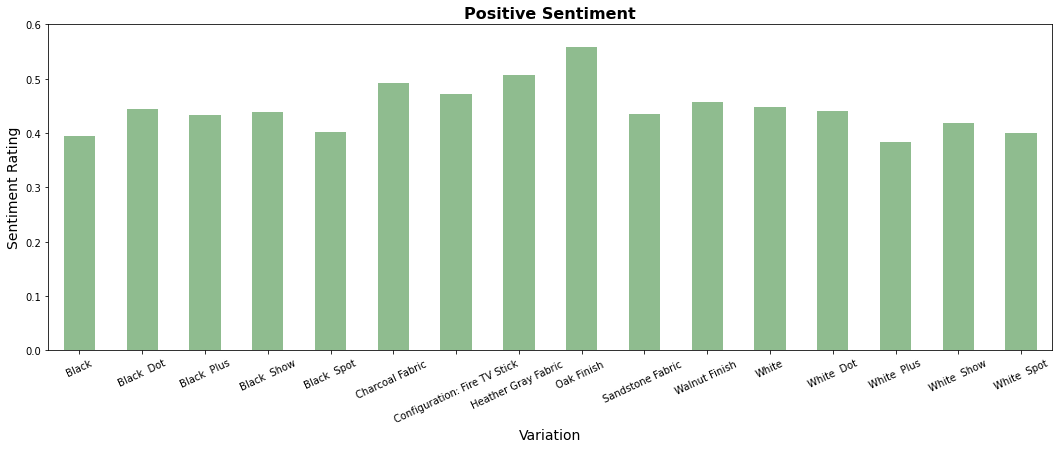

In [24]:
plt.figure(figsize=(18,6))

df.groupby('variation')['pos'].mean().plot.bar(color='darkseagreen')
plt.title('Positive Sentiment', fontsize=16, weight='bold')
plt.xlabel('Variation', fontsize=14)
plt.xticks(rotation='25')
plt.ylabel('Sentiment Rating', fontsize=14)
plt.ylim([0,0.6])
plt.show()

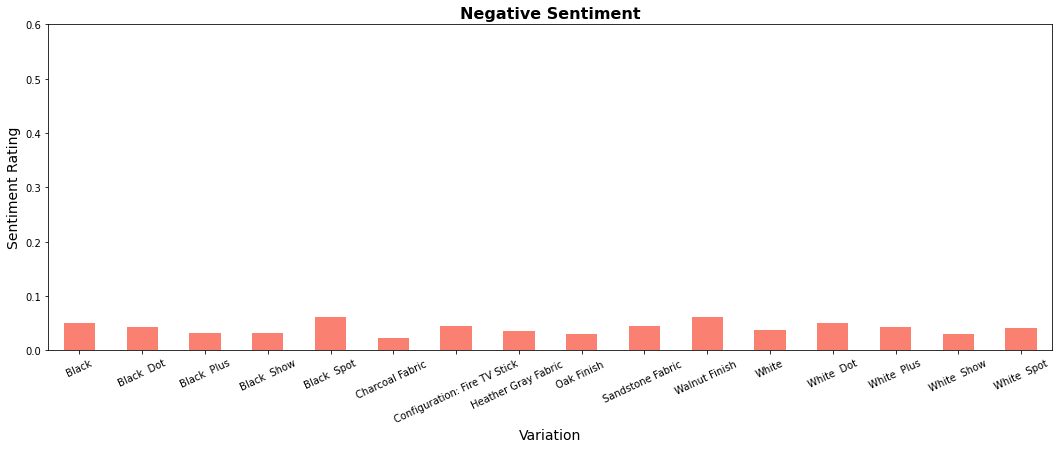

In [25]:
plt.figure(figsize=(18,6))

df.groupby('variation')['neg'].mean().plot.bar(color='salmon')
plt.title('Negative Sentiment', fontsize=16, weight='bold')
plt.xlabel('Variation', fontsize=14)
plt.xticks(rotation='25')
plt.ylabel('Sentiment Rating', fontsize=14)
plt.ylim([0,0.6])
plt.show()

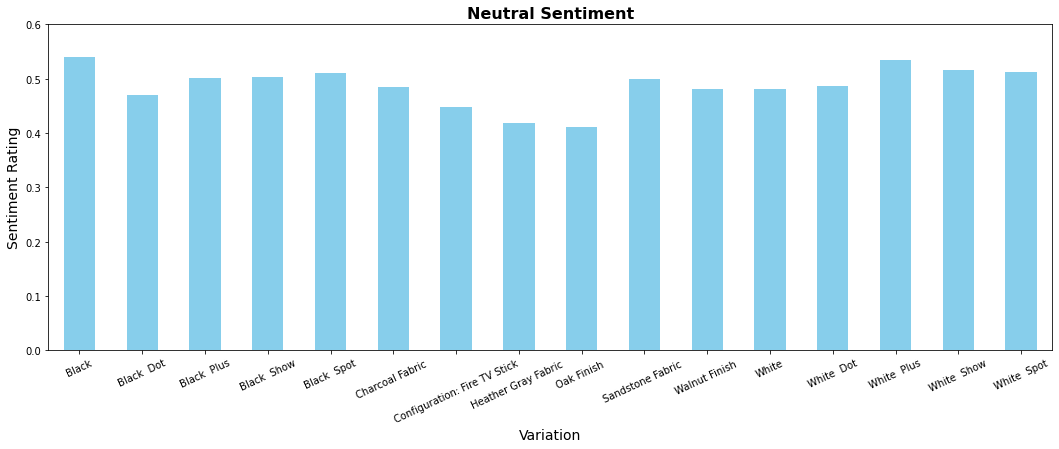

In [26]:
plt.figure(figsize=(18,6))

df.groupby('variation')['neu'].mean().plot.bar(color='skyblue')
plt.title('Neutral Sentiment', fontsize=16, weight='bold')
plt.xlabel('Variation', fontsize=14)
plt.xticks(rotation='25')
plt.ylabel('Sentiment Rating', fontsize=14)
plt.ylim([0,0.6])
plt.show()

## Sentiment Feature

In [27]:
neg_alexa = df[df['sentiment']=='negative']
pos_alexa = df[df['sentiment']=='positive']

In [28]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(ngram_range=(2, 2))
X_tfidf = tfidf.fit_transform(neg_alexa['verified_reviews'])
y = neg_alexa['rating']
chi2score = chi2(X_tfidf, y)[0]

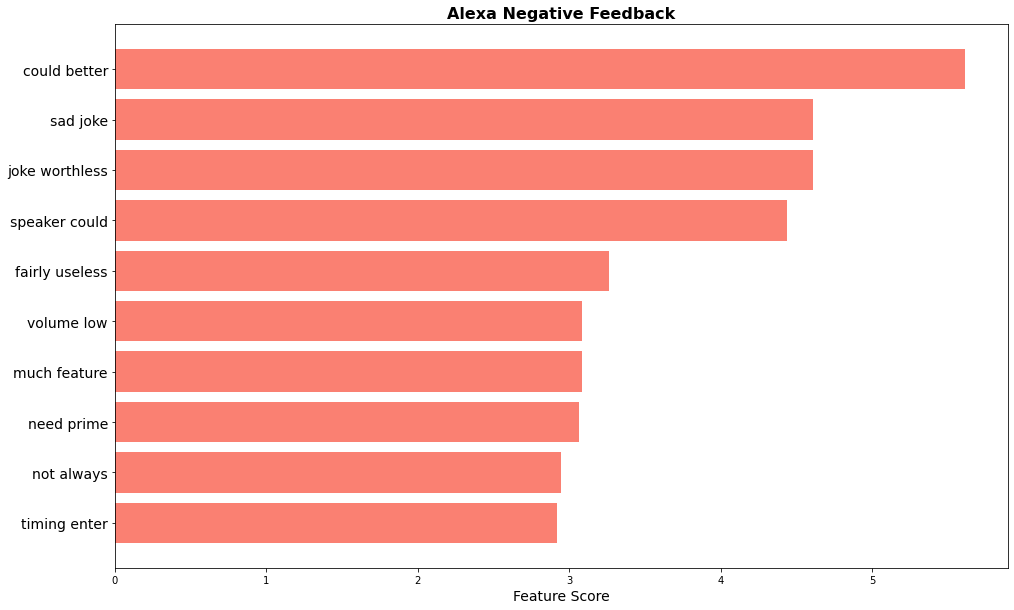

In [29]:
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2_n = sorted(scores, key=lambda x: x[1])
topchi2 = list(zip(*chi2_n[-10:]))
x = range(len(topchi2[1]))

plt.figure(figsize=(16,10))
plt.barh(x, topchi2[1], align='center', color='salmon')
plt.title('Alexa Negative Feedback', fontsize=16, weight='bold')
plt.xlabel("Feature Score", fontsize=14)
labels = topchi2[0]
plt.yticks(x, labels, fontsize=14)
plt.show()

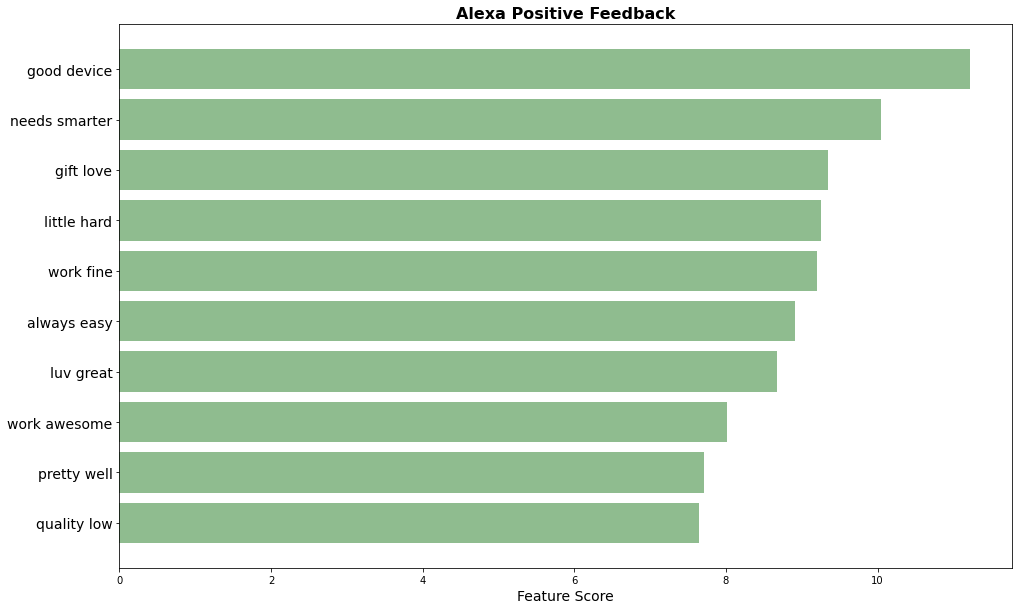

In [30]:
X_tfidf = tfidf.fit_transform(pos_alexa['verified_reviews'])
y = pos_alexa['rating']
chi2score = chi2(X_tfidf, y)[0]
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2_n = sorted(scores, key=lambda x: x[1])
topchi2 = list(zip(*chi2_n[-10:]))
x = range(len(topchi2[1]))

plt.figure(figsize=(16,10))
plt.barh(x, topchi2[1], align='center', color='darkseagreen')
plt.title('Alexa Positive Feedback', fontsize=16, weight='bold')
plt.xlabel("Feature Score", fontsize=14)
labels = topchi2[0]
plt.yticks(x, labels, fontsize=14)
plt.show()